In [18]:
import numpy as np 
import mne 
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from src.gp_algorithms import Multiclass_GP

In [19]:
## Simulate two different time series
# First a sine based time series with random offset and phase
N = 100
T = 150
sine_TS = np.zeros((N, T))
x = np.linspace(0, 8*np.pi, T)
sigma = 0.5

for i in range(N):
    phase_shift = np.random.normal(0, np.pi)
    off_set = np.random.normal()
    noise = np.random.normal(0, sigma, T)
    sine_TS[i,:] = np.sin(x+phase_shift) + noise

In [20]:
## Then an AR(1) time series
AR_TS = np.zeros((N,T))
alpha = np.random.normal()
beta1 = 0.5*np.random.uniform(-1,1)
beta2 = 0.3*np.random.uniform(-1,1)

for i in range(N):
    AR_TS[i,0] = np.random.normal()
    AR_TS[i,1] = alpha + beta1*AR_TS[i,0] + np.random.normal(0, sigma)
    for t in range(2, T):
        noise = np.random.normal(0,sigma)
        AR_TS[i,t] = alpha + beta1*AR_TS[i,t-1] + beta2*AR_TS[i,t-2] + noise

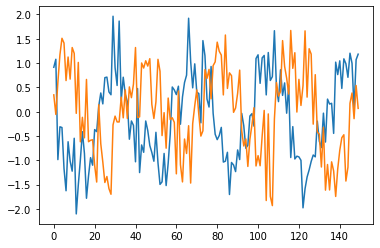

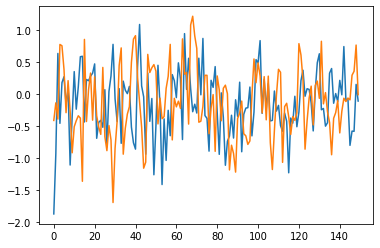

In [21]:
plt.plot(sine_TS[0,:])
plt.plot(sine_TS[1,:])
plt.show()

plt.plot(AR_TS[0,:])
plt.plot(AR_TS[1,:])
plt.show()

In [ ]:
# Test dynamic time warping
distance_sine, path_sine = fastdtw(sine_TS[0,:],sine_TS[1,:], dist=euclidean)
path_sine = np.array(path_sine)

distance_AR, path_AR = fastdtw(AR_TS[0,:],AR_TS[1,:], dist=euclidean)
path_AR = np.array(path_AR)

In [ ]:
plt.plot(sine_TS[0,:][path_sine[:,0]])
plt.plot(sine_TS[1,:][path_sine[:,1]])
plt.show()

plt.plot(AR_TS[0,:][path_AR[:,0]])
plt.plot(AR_TS[1,:][path_AR[:,1]])
plt.show()

In [ ]:
class AGDTW():
    def __init__(self, sigma):
        self.sigma = sigma
    
    def __call__(self, x, xstar = None):
        if xstar is not None:
            K = np.zeros((len(x), len(xstar)))
            for i in range(len(xstar)):
                print('Observation', i)
                for j in range(len(x)):
                    if (j-i)%20 == 0:
                        print(j-i, 'out of', len(x)-i)
                    _, path = fastdtw(xstar[i,:], x[j,:], dist=euclidean)
                    path = np.array(path)
                    dist = np.exp(-(xstar[i,path[:,0]] - x[j,path[:,1]])**2/self.sigma**2)
                    K[j,i] = np.sum(dist)

        else:
            K = np.zeros((len(x), len(x)))
            for i in range(len(x)):
                print('Observation', i)
                for j in range(i, len(x)):
                    if (j-i)%20 == 0:
                        print(j-i, 'out of', len(x)-i)
                    _, path = fastdtw(x[i,:], x[j,:], dist=euclidean)
                    path = np.array(path)
                    dist = np.exp(-(x[i,path[:,0]] - x[j,path[:,1]])**2/self.sigma**2)
                    K[j,i] = np.sum(dist)
                    
            # add lower triangle
            K = K + K.T - np.diag(K)
        return K

In [ ]:
class SquaredExponentialKernel:
    def __init__(self, l, sigmaf):
        self.l = l
        self.sigmaf = sigmaf
        
    def __call__(self, x, xstar = None):
        
        if xstar is not None:
            K = np.zeros((len(x), len(xstar)))

            for i in range(len(xstar)):
                temp = np.repeat(np.reshape(xstar[i,:],(1,-1)), len(x), axis = 0)
                dist = np.sum((x-temp)**2, axis = 1)
                K[:,i] = self.sigmaf**2*np.exp(-dist/(2*(self.l**2)))
        else:
            K = np.zeros((len(x), len(x)))

            for i in range(len(x)):
                temp = np.repeat(np.reshape(x[i,:],(1,-1)), len(x), axis = 0)
                dist = np.sum((x-temp)**2, axis = 1)
                K[:,i] = self.sigmaf**2*np.exp(-dist/(2*(self.l**2)))
            
        return K

In [ ]:
%%time
kernel = AGDTW(sigma = 10)
x = np.concatenate((AR_TS, sine_TS), axis = 0)

K1 = kernel(x)

In [ ]:
plt.matshow(K)
plt.show()

In [ ]:
from scipy.linalg import fractional_matrix_power, cholesky, cho_solve, block_diag

def Algorithm33(K, y, num_classes, maxiter=100, tol=1e-6):
    n = int(len(y)/num_classes)
    f = np.zeros(len(y))
    f_temp = np.array([f[c*n:(c+1)*n] for c in range(num_classes)]).T
    i = 0
    log_marginal_likelihood = -np.inf

    while True:
        i+=1
        pi_temp = np.exp(f_temp)/np.sum(np.exp(f_temp), axis = 1)[:,np.newaxis] # eq 3.34
        pi = np.reshape(pi_temp,(num_classes*n),order= 'F')

        PI = np.zeros((num_classes*n,n))
        E = np.zeros((num_classes*n,n))
        z = np.zeros(num_classes)
        M_temp = np.zeros((n,n))

        for c in range(num_classes): 
            pi_c = pi[c*n:(c+1)*n]
            PI[c*n:(c+1)*n,:] = np.diag(pi_c) # eq 3.38
            K_c = K[c*n:(c+1)*n, :]
            pi_K = np.sqrt(pi_c)[:, np.newaxis] * K_c * np.sqrt(pi_c)
            L = cholesky(np.identity(n)+pi_K, lower =True)
            temp = cho_solve((L, True), np.diag(np.sqrt(pi_c)))
            E[c*n:(c+1)*n,:] = np.sqrt(pi_c)[:, np.newaxis]*temp
            M_temp = M_temp + E[c*n:(c+1)*n,:]
            z[c] = np.sum(np.log(np.diag(L)))

        M = cholesky(M_temp, lower = True)
        
        # eq. 3.39
        b = np.matmul(np.diag(pi)-np.matmul(PI,PI.T), f) + y - pi 
        # eq. 3.39 using 3.45 and 3.47
        temp = np.reshape([np.dot(K[c*n:(c+1)*n,:],b[c*n:(c+1)*n]) \
                           for c in range(num_classes)], (num_classes*n))
        c = np.reshape([np.dot(E[c*n:(c+1)*n,:],temp[c*n:(c+1)*n]) \
                        for c in range(num_classes)], (num_classes*n)) 
        R_c = np.sum([c[i*n:(i+1)*n] for i in range(num_classes)], axis = 0).T
        a = b - c + np.dot(E, cho_solve((M,True), R_c))

        f_new = np.reshape([np.dot(K[c*n:(c+1)*n, :], a[c*n:(c+1)*n]) \
                        for c in range(num_classes)], num_classes*n) 
        diff = abs(f_new-f)
        f = f_new
        # Approximate marginal log likelihood
        f_temp = np.array([f[c*n:(c+1)*n] for c in range(num_classes)]).T
        lml = -1/2*np.sum(a*f) + np.sum(y*f) + \
              np.sum(np.log(np.sum(np.exp(f_temp), axis = 1))) - \
              np.sum(z) # eq 3.44
        
        if i==maxiter or np.mean(diff) < tol:
            log_marginal_likelihood = lml
            break
        log_marginal_likelihood = lml
    
    return f, diff, i, log_marginal_likelihood

In [22]:
## Simulate multiclass problem
mu = [[-10,-10], [0, 0], [10, 10]]
sig = 1.5
N = 100

x = np.zeros((3*N,2))
y = np.zeros((3*N,3))
for i in range(3*N):
    if i < N:
        mean = mu[0]
        y[i,0] = 1
    elif i < 2*N:
        mean = mu[1]
        y[i,1] = 1
    else:
        mean = mu[2]
        y[i,2] = 1
    x[i,:] = np.random.multivariate_normal(mean, sig*np.eye(2))

y = np.reshape(y, 3*3*N, order = 'F')


In [23]:
SE = SquaredExponentialKernel(l = 4, sigmaf = 1)
K_temp = SE(x)
K = np.concatenate((np.concatenate((K_temp, K_temp)), K_temp)) # use the same kernel for all three classes

In [24]:
MC_GP = Multiclass_GP(SE, y, 3, K=K)
f, stats = MC_GP.inference()

In [25]:
stats['it']

array([ 2.0593831 ,  2.03080621,  1.92525527,  1.99004802,  2.016751  ,
        1.90724178,  1.92047979,  1.88825139,  1.92162153,  1.90384345,
        2.05680473,  1.98045139,  1.89038329,  2.02989036,  1.56143743,
        2.05720187,  2.01783366,  1.87059033,  2.05573555,  1.93807354,
        1.89116384,  1.58701578,  1.99638467,  2.01956707,  1.93367288,
        1.97741696,  1.68214224,  1.74034098,  1.80936913,  2.04499103,
        1.98887307,  1.59022018,  2.05499344,  2.0388517 ,  2.03874392,
        2.05447098,  1.961052  ,  1.908117  ,  1.76792651,  2.05815961,
        1.84588748,  1.59423635,  1.81901374,  2.0342842 ,  2.00618666,
        2.02565805,  1.85108992,  1.92897922,  2.02079326,  1.8689124 ,
        2.04065504,  2.04029159,  1.87686685,  2.0369721 ,  1.97853051,
        1.9624221 ,  1.85980984,  1.93022663,  1.94722054,  2.05494467,
        2.05443054,  1.83012659,  2.01104182,  1.99576697,  2.05414259,
        2.00752703,  2.06060367,  1.97474984,  1.81204076,  1.63

In [ ]:
plt.matshow(K)
plt.show()

In [ ]:
f, diff, i, log_marginal_likelihood = Algorithm33(K, y, 3, maxiter=50, tol=1e-10)

In [ ]:
i

In [ ]:
f_temp = np.array([f[c*n:(c+1)*n] for c in range(3)]).T
np.argmax(f_temp,axis =1)

In [ ]:
n = 3
temp = [1,2,3,4,5,6,7,8,9]
f_temp = np.array([temp[c*n:(c+1)*n] for c in range(3)]).T
np.reshape(f_temp, 9, order='F')

In [ ]:
n = 300
f = np.ones(n)
f_temp = np.array([f[c*n:(c+1)*n] for c in range(3)]).T

In [ ]:
num_classes = 3
n = int(len(y)/num_classes)
print(n)
f = np.zeros(len(y))
f_temp = np.array([f[c*n:(c+1)*n] for c in range(num_classes)]).T
print(f_temp.shape)
i = 0
log_marginal_likelihood = -np.inf
maxiter = 1
tol = 1e-8
while True:
    i+=1
    pi_temp = np.exp(f_temp)/np.sum(np.exp(f_temp), axis = 1)[:,np.newaxis] # eq 3.34
    pi = np.reshape(pi_temp,(num_classes*n),order= 'F')

    PI = np.zeros((num_classes*n,n))
    E = np.zeros((num_classes*n,n))
    z = np.zeros(num_classes)
    M_temp = np.zeros((n,n))

    for c in range(num_classes): 
        pi_c = pi[c*n:(c+1)*n]
        PI[c*n:(c+1)*n,:] = np.diag(pi_c) # eq 3.38
        K_c = K[c*n:(c+1)*n, :]
        pi_K = np.sqrt(pi_c)[:, np.newaxis] * K_c * np.sqrt(pi_c)
        L = cholesky(np.identity(n)+pi_K, lower =True)
        temp = cho_solve((L, True), np.diag(np.sqrt(pi_c)))
        E[c*n:(c+1)*n,:] = np.sqrt(pi_c)[:, np.newaxis]*cho_solve((L, True), temp)
        M_temp = M_temp + E[c*n:(c+1)*n,:]
        z[c] = np.sum(np.log(np.diag(L)))

    M = cholesky(M_temp, lower = True)
    
    # eq. 3.39
    b = np.matmul(np.diag(pi)-np.matmul(PI,PI.T), f) + y - pi 
    # eq. 3.39 using 3.45 and 3.47
    temp = np.reshape([np.dot(K[c*n:(c+1)*n,:],b[c*n:(c+1)*n]) \
                        for c in range(num_classes)], (num_classes*n))
    c = np.reshape([np.dot(E[c*n:(c+1)*n,:],temp[c*n:(c+1)*n]) \
                    for c in range(num_classes)], (num_classes*n)) 
    R_c = np.sum([c[i*n:(i+1)*n] for i in range(num_classes)], axis = 0).T
    temp = cho_solve((M.T, True), cho_solve((M,True), R_c))
    a = b - c + np.dot(E, temp)

    f = np.reshape([np.dot(K[c*n:(c+1)*n, :], a[c*n:(c+1)*n]) \
                    for c in range(num_classes)], num_classes*n) 

    # Approximate marginal log likelihood
    f_temp = np.array([f[c*n:(c+1)*n] for c in range(num_classes)]).T
    lml = -1/2*np.sum(a*f) + np.sum(y*f) + \
            np.sum(np.log(np.sum(np.exp(f_temp), axis = 1))) - \
            np.sum(z) # eq 3.44

    if i==maxiter or lml - log_marginal_likelihood < tol:
        log_marginal_likelihood = lml
        break
    log_marginal_likelihood = lml
    

In [ ]:
temp = [np.dot(K[c*n:(c+1)*n,:],b[c*n:(c+1)*n]) \
                        for c in range(num_classes)]
np.reshape(temp, num_classes*n)[0:n]==temp[0]